In [30]:
import os
import glob
import shutil
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import yaml
import albumentations as A


In [2]:
def extract_classes(kaggle_dir: Path):
    """
    Liest alle XML-Dateien unter kaggle_dir/annotations
    und gibt eine sortierte Liste aller eindeutigen Klassen zurück.
    """
    xml_paths = list((kaggle_dir/"annotations").glob("*.xml"))
    classes = set()
    for p in xml_paths:
        root = ET.parse(p).getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            classes.add(name)
    return sorted(classes)

kaggle_dir = Path("../kaggle")
kaggle_yolo_dir = Path("../kaggle_yolo")
class_list = extract_classes(kaggle_dir)
print("Gefundene Klassen:", class_list)

Gefundene Klassen: ['cat', 'dog']


In [3]:
# mapping
label2id = {name: idx for idx, name in enumerate(class_list)}
print("Mapping:", label2id)

# yaml datei erstellen
cfg = {
    'path': str(kaggle_yolo_dir.resolve()),
    'train': 'train/images',
    'valid':   'valid/images',
    'test':  'test/images',
    'nc':    len(class_list),
    'names': class_list
}

with open(kaggle_yolo_dir/"data.yaml", "w") as f:
    yaml.dump(cfg, f, default_flow_style=False)

print("✔ data.yaml geschrieben:", (kaggle_yolo_dir/"data.yaml"))

Mapping: {'cat': 0, 'dog': 1}
✔ data.yaml geschrieben: ../kaggle_yolo/data.yaml


In [4]:
def convert_kaggle_to_yolo(kaggle_dir: Path,
                           out_dir: Path,
                           label2id: dict,
                           split_ratios=(0.8,0.1,0.1),
                           seed=42):
    """
    - Liest alle XMLs unter kaggle_dir/annotations und images unter kaggle_dir/images
    - Splittet nach split_ratios in train/val/test
    - Schreibt Bilder nach out_dir/{train,val,test}/images
    - Schreibt TXT mit Klassen-IDs nach out_dir/{train,val,test}/labels
    """
    random.seed(seed)
    img_paths = list((kaggle_dir/"images").glob("*.[jp][pn]g"))
    bases = [p.stem for p in img_paths]

    # Splitting
    train_b, test_b = train_test_split(bases, test_size=split_ratios[2], random_state=seed)
    train_b, val_b  = train_test_split(train_b,
                        test_size=split_ratios[1]/(split_ratios[0]+split_ratios[1]),
                        random_state=seed)

    for split_name, names in [("train", train_b), ("val", val_b), ("test", test_b)]:
        img_out = out_dir/split_name/"images"
        lbl_out = out_dir/split_name/"labels"
        img_out.mkdir(parents=True, exist_ok=True)
        lbl_out.mkdir(parents=True, exist_ok=True)

        for stem in names:
            # 1) Bild kopieren
            src_img = None
            for ext in [".jpg",".png"]:
                cand = kaggle_dir/"images"/(stem+ext)
                if cand.exists():
                    src_img = cand
                    break
            if not src_img:
                continue
            shutil.copy(src_img, img_out)

            # 2) XML einlesen
            xml_f = kaggle_dir/"annotations"/f"{stem}.xml"
            if not xml_f.exists():
                continue
            tree = ET.parse(xml_f); root = tree.getroot()
            w = int(root.find("size/width").text)
            h = int(root.find("size/height").text)

            # 3) YOLO-BB-Zeilen erzeugen
            lines = []
            for obj in root.findall("object"):
                cls = obj.find("name").text.strip()
                if cls not in label2id:
                    continue
                cid = label2id[cls]
                bb = obj.find("bndbox")
                xmin, ymin = int(bb.find("xmin").text), int(bb.find("ymin").text)
                xmax, ymax = int(bb.find("xmax").text), int(bb.find("ymax").text)
                x_c = ((xmin + xmax)/2) / w
                y_c = ((ymin + ymax)/2) / h
                bw  = (xmax - xmin) / w
                bh  = (ymax - ymin) / h
                lines.append(f"{cid} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")

            # 4) TXT speichern
            with open(lbl_out/f"{stem}.txt", "w") as f:
                f.write("\n".join(lines))

    print("✔ Kaggle-Konvertierung abgeschlossen.")

In [5]:
out_dir = Path("../kaggle_yolo")
convert_kaggle_to_yolo(kaggle_dir, out_dir, label2id)

✔ Kaggle-Konvertierung abgeschlossen.


In [6]:
# Pfad zur data.yaml
cfg_path = Path("../DOG.v1i.yolov8/data.yaml")

# Laden und anpassen
with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)

cfg['nc'] = 1
cfg['names'] = ['dog']

# Zurückschreiben
with open(cfg_path, 'w') as f:
    yaml.dump(cfg, f, default_flow_style=False)

print(f"✅ Updated {cfg_path}: nc={cfg['nc']}, names={cfg['names']}")

✅ Updated ../DOG.v1i.yolov8/data.yaml: nc=1, names=['dog']


In [7]:
base = Path("../DOG.v1i.yolov8")
SPLITS = ["train", "valid", "test"]

In [8]:
for split in SPLITS:
    lbl_dir = base/split/"labels"
    if not lbl_dir.exists():
        continue

    for txt_file in lbl_dir.glob("*.txt"):
        lines = txt_file.read_text().splitlines()
        new_lines = []
        for L in lines:
            parts = L.strip().split()
            if len(parts) >= 5:
                # setze die Klassennummer immer auf 0
                parts[0] = '0'
                new_lines.append(' '.join(parts))
        # zurückschreiben (mit Zeilenumbruch am Ende)
        txt_file.write_text("\n".join(new_lines) + "\n")
        print(f"  ✔ {split}/labels/{txt_file.name} angepasst")

  ✔ train/labels/images-2-_jpg.rf.c071fbcdd2dee3cc0e53c8f2c6037893.txt angepasst
  ✔ train/labels/9k-2-_jpg.rf.c5147c6feb1f3de25b4bfd51b22172f9.txt angepasst
  ✔ train/labels/9k-11-_jpg.rf.36848f02c2bdf1a609fb7c578d62349a.txt angepasst
  ✔ train/labels/9k-6-_jpg.rf.0a3eaec7f861918bb461467873f2d675.txt angepasst
  ✔ train/labels/9k-2-_jpg.rf.9400294923eff2f9dcb13cb2227ef9c5.txt angepasst
  ✔ train/labels/9k-7-_jpg.rf.3f1c385de5854a8fe20fbdf3fa080b0f.txt angepasst
  ✔ train/labels/2Q-9-_jpg.rf.92c64b6c708c74f39b87bbab9dea36d7.txt angepasst
  ✔ train/labels/9k-6-_jpg.rf.2b5b571d25af52b0edd72625eeb391f9.txt angepasst
  ✔ train/labels/2Q-9-_jpg.rf.ed9e6132740d4a9bb40318e0389a60ae.txt angepasst
  ✔ train/labels/2Q-9-_jpg.rf.84b99f41d6cbd9bc31a4c6e4fe598f07.txt angepasst
  ✔ train/labels/2Q-11-_jpg.rf.862b01f7a31717f42b9c5e4f152563d4.txt angepasst
  ✔ train/labels/9k-8-_jpg.rf.175e8322c21cea1f15fbe04a1cabb641.txt angepasst
  ✔ train/labels/9k-9-_jpg.rf.284d5b0a148fc7802fcf90e4fa5570f9.txt ang

In [9]:
DATASETS = [
    Path("../DOG.v1i.yolov8"),
    Path("../Dogs.v5i.yolov8"),
    Path("../ASDF.v1i.yolov8"),
    Path("../kaggle_yolo")
]

In [10]:
for ds in DATASETS:
    cfg_path = ds/"data.yaml"
    if not cfg_path.exists():
        print(f"⚠️  Keine data.yaml in {ds}, übersprungen.")
        continue

    # 1. config einlesen und dog_idx bestimmen
    cfg = yaml.safe_load(cfg_path.read_text())
    try:
        dog_idx = cfg["names"].index("dog")
    except ValueError:
        print(f"⚠️  'dog' nicht in names von {ds.name}, übersprungen.")
        continue

    # 2. aus den Pfaden in der YAML die Image-Ordner ableiten
    splits = {}
    for key in ("train","val","test"):
        if key in cfg:
            # cfg[key] ist z.B. "train/images" oder "valid/images"
            rel = Path(cfg[key])
            splits[key] = ds/rel

    # 3. pro Split alle Bilder ohne dog löschen
    for key, img_dir in splits.items():
        lbl_dir = img_dir.parent/"labels"
        if not img_dir.exists():
            print(f"   ⏭ {ds.name}/{key}/images nicht vorhanden")
            continue

        for img_p in img_dir.glob("*.*g"):
            txt_p = lbl_dir/(img_p.stem + ".txt")
            keep = False
            if txt_p.exists():
                for line in txt_p.read_text().splitlines():
                    if not line: continue
                    if int(line.split()[0]) == dog_idx:
                        keep = True
                        break

            if not keep:
                img_p.unlink()
                if txt_p.exists(): txt_p.unlink()
                print(f"  removed (no dog) → {ds.name}/{key}/images/{img_p.name}")

    print(f"✅ Bereinigt: {ds.name} (dog_idx = {dog_idx})\n")

   ⏭ DOG.v1i.yolov8/train/images nicht vorhanden
   ⏭ DOG.v1i.yolov8/val/images nicht vorhanden
   ⏭ DOG.v1i.yolov8/test/images nicht vorhanden
✅ Bereinigt: DOG.v1i.yolov8 (dog_idx = 0)

   ⏭ Dogs.v5i.yolov8/train/images nicht vorhanden
   ⏭ Dogs.v5i.yolov8/val/images nicht vorhanden
   ⏭ Dogs.v5i.yolov8/test/images nicht vorhanden
✅ Bereinigt: Dogs.v5i.yolov8 (dog_idx = 1)

   ⏭ ASDF.v1i.yolov8/train/images nicht vorhanden
   ⏭ ASDF.v1i.yolov8/val/images nicht vorhanden
   ⏭ ASDF.v1i.yolov8/test/images nicht vorhanden
✅ Bereinigt: ASDF.v1i.yolov8 (dog_idx = 2)

  removed (no dog) → kaggle_yolo/train/images/Cats_Test2507.png
  removed (no dog) → kaggle_yolo/train/images/Cats_Test2905.png
  removed (no dog) → kaggle_yolo/train/images/Cats_Test613.png
  removed (no dog) → kaggle_yolo/train/images/Cats_Test3437.png
  removed (no dog) → kaggle_yolo/train/images/Cats_Test2670.png
  removed (no dog) → kaggle_yolo/train/images/Cats_Test2173.png
  removed (no dog) → kaggle_yolo/train/images/Ca

In [11]:
# Pfade zu deinen data.yaml
yamls = [
    Path("../DOG.v1i.yolov8/data.yaml"),
    Path("../Dogs.v5i.yolov8/data.yaml"),
    Path("../ASDF.v1i.yolov8/data.yaml"),
    Path("../kaggle_yolo/data.yaml")
]

In [12]:
for y in yamls:
    cfg = yaml.safe_load(y.read_text())
    cfg['nc'] = 1
    cfg['names'] = ['dog']
    cfg['train'] = 'train/images'
    cfg['val']   = 'valid/images'
    cfg['test']  = 'test/images'
    cfg.pop('roboflow', None)  # falls noch drin

    with open(y, 'w') as f:
        yaml.dump(cfg, f, default_flow_style=False)
    print(f"✅ {y.name} angepasst.")

✅ data.yaml angepasst.
✅ data.yaml angepasst.
✅ data.yaml angepasst.
✅ data.yaml angepasst.


In [13]:
# 1) Definiere für jedes Dataset den alten Dog-Index (None = alle Klassen → 0)
mappings = {
    Path("../ASDF.v1i.yolov8"):   2,   # dort war dog=2
    Path("../Dogs.v5i.yolov8"):   1,   # dort war dog=1
    Path("../kaggle_yolo"):      None, # dort sollen _alle_ labels → 0
}

splits = ["train", "valid", "test"]

for ds, old_idx in mappings.items():
    for split in splits:
        lbl_dir = ds / split / "labels"
        if not lbl_dir.exists():
            continue

        for txt_file in lbl_dir.glob("*.txt"):
            lines = txt_file.read_text().splitlines()
            new = []
            for L in lines:
                parts = L.strip().split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                # wenn old_idx None → immer umsetzen; sonst nur, wenn matches
                if old_idx is None or cls == old_idx:
                    parts[0] = "0"
                    new.append(" ".join(parts))
                # sonst: ignorieren (keine andere Klasse übernehmen)

            # Datei mit den neuen Zeilen überschreiben
            txt_file.write_text("\n".join(new) + ("\n" if new else ""))
            print(f"→ {ds.name}/{split}/labels/{txt_file.name}: {len(new)} dog-bboxes")

→ ASDF.v1i.yolov8/train/labels/youtube-0_jpg.rf.8faea3082ab92487c32916c50b68d79b.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/8_jpg.rf.c096c1cee7dc5486d0614340939979bb.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-33_jpg.rf.1b21fa175ac7dbaaa7436834652c7594.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-32_jpg.rf.e36ad5556f6b10aafa84e16c0a9640b0.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-17_jpg.rf.c1f3e5955de0b6c7b8993a02e380c2ad.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-32_jpg.rf.1b82482d5f859a1f0e911d101372aacb.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-53_jpg.rf.986baff8b90622cf74e48131aa71d5f8.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-53_jpg.rf.fa95388275b9b558053f9a325dcfd956.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-47_jpg.rf.5e5151991cf6a5f8f07d77f2db6da455.txt: 1 dog-bboxes
→ ASDF.v1i.yolov8/train/labels/youtube-5_jpg.rf.a80ddccfa445db2c88bd397a5c320efa.txt: 1 dog-bboxes
→ ASDF.v1i.

In [14]:
for ds in DATASETS:
    for split in SPLITS:
        img_dir = ds / split / "images"
        lbl_dir = ds / split / "labels"
        if not img_dir.exists() or not lbl_dir.exists():
            continue

        for img_path in img_dir.glob("*.*g"):
            txt_path = lbl_dir / f"{img_path.stem}.txt"

            # 1) Kein Label vorhanden → Bild löschen
            if not txt_path.exists():
                img_path.unlink()
                print(f"Removed image without label: {ds.name}/{split}/images/{img_path.name}")

            else:
                # 2) Label-Datei ist leer → Bild und Label löschen
                if not txt_path.read_text().strip():
                    img_path.unlink()
                    txt_path.unlink()
                    print(f"Removed empty label and image: {ds.name}/{split}/{img_path.name}")

Removed empty label and image: Dogs.v5i.yolov8/train/29_jpg.rf.2d2c9482275abbec64c750daf4841eb2.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/72_jpg.rf.3f47000daf6f6c53b9c46dfe47125466.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/60_jpg.rf.db05f74ca133d3e490152b7276ebe0af.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/83_jpg.rf.f2005f5d8925dca0d615307606925afe.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/59_jpg.rf.b347416c87f574a790656cb8720e06aa.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/89_jpg.rf.a88845d89fb1d98f38b3643fbd03fb94.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/24_jpg.rf.2600a2cea2efd512e8b058996e84f7b9.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/215_jpg.rf.b7427ecb5283c0b7cc60c992156ee3ca.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/226_jpg.rf.b8bc0aa172426f1caeb1dcfae4dc8fe8.jpg
Removed empty label and image: Dogs.v5i.yolov8/train/38_jpg.rf.032e9d1e056bd68fa28bed6835af2cc0.jp

In [16]:
OLD_SPLITS = ["train", "valid", "test"]
# Die neuen Anteile
TRAIN_RATIO = 0.70
VALID_RATIO = 0.15  # von allen
TEST_RATIO  = 0.15

SEED = 42
random.seed(SEED)

for ds in DATASETS:
    print(f"\n=== In-Place Resplit {ds.name} (70/15/15) ===")
    # 2) Sammle alle Bild-/Label-Paare aus allen alten Splits
    pairs = []
    for split in OLD_SPLITS:
        img_dir = ds / split / "images"
        lbl_dir = ds / split / "labels"
        if not img_dir.exists() or not lbl_dir.exists():
            continue
        for img_p in img_dir.glob("*.*g"):
            lbl_p = lbl_dir / f"{img_p.stem}.txt"
            if lbl_p.exists():
                pairs.append((img_p, lbl_p))
    print(f"Found {len(pairs)} labeled images total")
    if not pairs:
        print(" → keine Paare gefunden, skip.")
        continue

    # 3) Shuffle & neue Splits berechnen
    train_pairs, rest = train_test_split(pairs, train_size=TRAIN_RATIO, random_state=SEED)
    valid_pairs, test_pairs = train_test_split(
        rest, train_size=VALID_RATIO/(VALID_RATIO+TEST_RATIO), random_state=SEED
    )
    new_splits = {
        "train": train_pairs,
        "valid": valid_pairs,
        "test":  test_pairs
    }

    # 4) Erstelle temporäre Split-Ordner und fülle sie
    for split, split_pairs in new_splits.items():
        tmp_img = ds / f"{split}_tmp" / "images"
        tmp_lbl = ds / f"{split}_tmp" / "labels"
        tmp_img.mkdir(parents=True, exist_ok=True)
        tmp_lbl.mkdir(parents=True, exist_ok=True)

        for img_p, lbl_p in split_pairs:
            shutil.copy2(img_p, tmp_img / img_p.name)
            shutil.copy2(lbl_p, tmp_lbl / lbl_p.name)
        print(f"  {split:5s} tmp: {len(split_pairs)} images → {tmp_img.parent}")

    # 5) Lösche die alten Split-Ordner und benenne tmp um
    for split in OLD_SPLITS:
        old_split = ds / split
        tmp_split = ds / f"{split}_tmp"
        if tmp_split.exists():
            if old_split.exists():
                shutil.rmtree(old_split)
            tmp_split.rename(old_split)
            print(f"  replaced {old_split} with new {tmp_split.name}")

print("\n✅ Resplit (70/15/15) abgeschlossen.")


=== In-Place Resplit DOG.v1i.yolov8 (70/15/15) ===
Found 258 labeled images total
  train tmp: 180 images → ../DOG.v1i.yolov8/train_tmp
  valid tmp: 39 images → ../DOG.v1i.yolov8/valid_tmp
  test  tmp: 39 images → ../DOG.v1i.yolov8/test_tmp
  replaced ../DOG.v1i.yolov8/train with new train_tmp
  replaced ../DOG.v1i.yolov8/valid with new valid_tmp
  replaced ../DOG.v1i.yolov8/test with new test_tmp

=== In-Place Resplit Dogs.v5i.yolov8 (70/15/15) ===
Found 641 labeled images total
  train tmp: 448 images → ../Dogs.v5i.yolov8/train_tmp
  valid tmp: 96 images → ../Dogs.v5i.yolov8/valid_tmp
  test  tmp: 97 images → ../Dogs.v5i.yolov8/test_tmp
  replaced ../Dogs.v5i.yolov8/train with new train_tmp
  replaced ../Dogs.v5i.yolov8/valid with new valid_tmp
  replaced ../Dogs.v5i.yolov8/test with new test_tmp

=== In-Place Resplit ASDF.v1i.yolov8 (70/15/15) ===
Found 80 labeled images total
  train tmp: 56 images → ../ASDF.v1i.yolov8/train_tmp
  valid tmp: 12 images → ../ASDF.v1i.yolov8/valid_tm

In [17]:
def train_yolo(name, data_yaml, epochs=20, imgsz=640, batch=4, workers=2):
    """
    Trainiert ein YOLOv8-Modell mit den gegebenen Parametern.
    - name: Name des Run-Ordners (runs/name)
    - data_yaml: Pfad zur Daten-YAML
    """
    model = YOLO('yolov8n.pt')
    model.train(
        data      = data_yaml,
        imgsz     = imgsz,
        epochs    = epochs,
        batch     = batch,
        workers   = workers,
        project   = 'runs',
        name      = name,
        exist_ok  = True
    )
    print(f"✅ Training {name} abgeschlossen.")

In [18]:
# Pfad zur YAML im DOG.v1i-Ordner
yaml_path = '../DOG.v1i.yolov8/data.yaml'
train_yolo('dog_v1i', yaml_path, epochs=20, batch=8, workers=4)

Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../DOG.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dog_v1i, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

train: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/DOG.v1i.yolov8/train/labels... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1769.99it/s]

train: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/DOG.v1i.yolov8/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 83.3±26.5 MB/s, size: 43.1 KB)


val: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/DOG.v1i.yolov8/valid/labels... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<00:00, 1232.54it/s]

val: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/DOG.v1i.yolov8/valid/labels.cache


Plotting labels to runs/dog_v1i/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/dog_v1i
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.13G      1.218      3.082      1.651         12        640: 100%|██████████| 23/23 [00:03<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all         39         58    0.00372      0.748      0.172     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.39G      1.177      2.597      1.646          9        640: 100%|██████████| 23/23 [00:01<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.18it/s]

                   all         39         58     0.0035      0.713      0.206      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.41G      1.192      2.463      1.672         11        640: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.98it/s]

                   all         39         58        0.2      0.357      0.189     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.41G      1.231      2.494      1.678         11        640: 100%|██████████| 23/23 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.91it/s]

                   all         39         58       0.15        0.2      0.109     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.44G      1.226      2.438      1.676         11        640: 100%|██████████| 23/23 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.08it/s]

                   all         39         58      0.107      0.346      0.134     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.46G      1.207      2.363      1.686          9        640: 100%|██████████| 23/23 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.08it/s]

                   all         39         58      0.187       0.45      0.197       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.47G      1.238      2.328      1.689         15        640: 100%|██████████| 23/23 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.95it/s]

                   all         39         58      0.253      0.493      0.263      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.49G      1.195      2.256      1.641          8        640: 100%|██████████| 23/23 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.73it/s]

                   all         39         58       0.33      0.439      0.257      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.51G      1.202      2.194      1.618         18        640: 100%|██████████| 23/23 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.02it/s]

                   all         39         58      0.315      0.351      0.311      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.53G      1.177      2.195      1.609          8        640: 100%|██████████| 23/23 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.18it/s]

                   all         39         58      0.475      0.406      0.387      0.202


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.54G      1.166      2.605      1.819          4        640: 100%|██████████| 23/23 [00:01<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.99it/s]

                   all         39         58      0.561      0.403      0.399       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.55G      1.088      2.427       1.72          4        640: 100%|██████████| 23/23 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.89it/s]

                   all         39         58      0.513      0.404      0.356      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.58G      1.097      2.348      1.681          6        640: 100%|██████████| 23/23 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.93it/s]

                   all         39         58      0.367      0.419       0.34      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.59G     0.9915      2.163      1.621          7        640: 100%|██████████| 23/23 [00:01<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.24it/s]

                   all         39         58      0.354       0.53      0.385      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.61G      1.047      2.134      1.671          6        640: 100%|██████████| 23/23 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.18it/s]

                   all         39         58      0.397      0.502      0.469      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.63G      1.029      2.108      1.618          6        640: 100%|██████████| 23/23 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.75it/s]

                   all         39         58      0.372      0.598      0.483      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.64G      0.931      2.027      1.565          4        640: 100%|██████████| 23/23 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.11it/s]

                   all         39         58      0.654      0.539      0.551      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.66G     0.9311      1.861      1.559          4        640: 100%|██████████| 23/23 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.52it/s]

                   all         39         58      0.659       0.52      0.569      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.68G     0.9086      1.781      1.521          5        640: 100%|██████████| 23/23 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.67it/s]

                   all         39         58      0.505      0.557      0.567      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.69G     0.8795      1.796      1.518          5        640: 100%|██████████| 23/23 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.98it/s]

                   all         39         58      0.492      0.594      0.579      0.392



20 epochs completed in 0.013 hours.
Optimizer stripped from runs/dog_v1i/weights/last.pt, 6.3MB
Optimizer stripped from runs/dog_v1i/weights/best.pt, 6.3MB

Validating runs/dog_v1i/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.32it/s]


                   all         39         58      0.491      0.594      0.579      0.392
               Abrador          9         20      0.434        0.3      0.417      0.296
             Chihuahua         14         20      0.575       0.65       0.63      0.453
             Shiba-Inu         16         18      0.465      0.833       0.69      0.427
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/dog_v1i
✅ Training dog_v1i abgeschlossen.


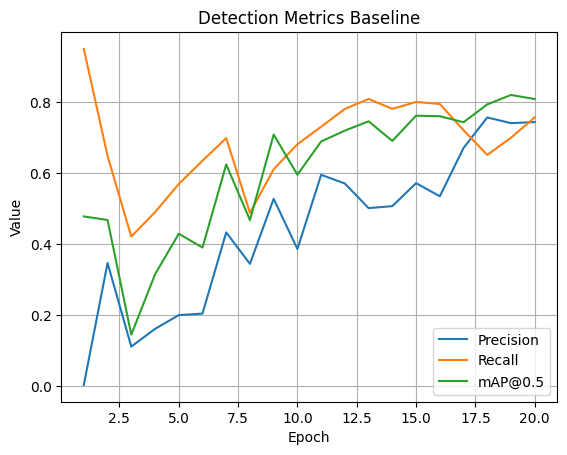

In [19]:
%matplotlib inline
results_dog_v1i = pd.read_csv('runs/dog_v1i/results.csv')

# Gruppieren nach Epoche und Mittelwert bilden
grouped_dog_v1i = results_dog_v1i.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped_dog_v1i.index, grouped_dog_v1i['metrics/precision(B)'], label='Precision')
plt.plot(grouped_dog_v1i.index, grouped_dog_v1i['metrics/recall(B)'], label='Recall')
plt.plot(grouped_dog_v1i.index, grouped_dog_v1i['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()

In [20]:
yaml_path = '../Dogs.v5i.yolov8/data.yaml'
train_yolo('dogs_v5i', yaml_path, epochs=20, batch=8, workers=4)

Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../Dogs.v5i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dogs_v5i, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

train: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/Dogs.v5i.yolov8/train/labels... 448 images, 0 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 1737.64it/s]

train: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/Dogs.v5i.yolov8/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 100.9±3.3 MB/s, size: 91.0 KB)


val: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/Dogs.v5i.yolov8/valid/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 1125.28it/s]

val: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/Dogs.v5i.yolov8/valid/labels.cache


Plotting labels to runs/dogs_v5i/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/dogs_v5i
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.31G      1.359      2.812      1.321         12        640: 100%|██████████| 56/56 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.30it/s]


                   all         96        133    0.00852       0.91      0.541      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.54G      1.297      1.974      1.287         16        640: 100%|██████████| 56/56 [00:04<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


                   all         96        133      0.857      0.539      0.757      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.54G      1.379      1.952      1.343         15        640: 100%|██████████| 56/56 [00:04<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


                   all         96        133      0.794      0.774      0.834      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.54G      1.322      1.756      1.341         21        640: 100%|██████████| 56/56 [00:04<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


                   all         96        133      0.875      0.736      0.852      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.54G      1.288      1.459      1.304         26        640: 100%|██████████| 56/56 [00:04<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.08it/s]


                   all         96        133      0.807      0.819      0.876      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.54G      1.293      1.393      1.327         16        640: 100%|██████████| 56/56 [00:04<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]


                   all         96        133       0.89      0.852       0.91      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.54G      1.187      1.276      1.271         14        640: 100%|██████████| 56/56 [00:04<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.85it/s]

                   all         96        133      0.916      0.903      0.939      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.54G      1.195      1.184      1.237         17        640: 100%|██████████| 56/56 [00:04<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.90it/s]

                   all         96        133      0.899      0.887      0.931      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.54G      1.118      1.116      1.199         14        640: 100%|██████████| 56/56 [00:04<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.93it/s]


                   all         96        133      0.949      0.902      0.956       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.54G      1.064     0.9807      1.188         15        640: 100%|██████████| 56/56 [00:04<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.98it/s]

                   all         96        133      0.961      0.921      0.955      0.711


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.56G      1.007     0.9785      1.222         10        640: 100%|██████████| 56/56 [00:04<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


                   all         96        133      0.908      0.896      0.936      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.58G     0.9638     0.8626      1.188         12        640: 100%|██████████| 56/56 [00:04<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.85it/s]

                   all         96        133      0.922      0.895      0.949       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.59G     0.9398      0.802       1.17         11        640: 100%|██████████| 56/56 [00:04<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]

                   all         96        133      0.954      0.955      0.964      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.61G     0.8934     0.7353      1.131          8        640: 100%|██████████| 56/56 [00:04<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.24it/s]

                   all         96        133      0.921      0.947       0.96      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.63G     0.8561     0.6964      1.109          9        640: 100%|██████████| 56/56 [00:04<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.25it/s]

                   all         96        133      0.962      0.962      0.968      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.64G     0.8208      0.652      1.083         12        640: 100%|██████████| 56/56 [00:04<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.18it/s]

                   all         96        133      0.962       0.97      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.66G     0.7969     0.6285       1.07          9        640: 100%|██████████| 56/56 [00:04<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.69it/s]


                   all         96        133      0.948      0.977      0.973      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.68G     0.7457     0.5815      1.045         10        640: 100%|██████████| 56/56 [00:04<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.22it/s]

                   all         96        133      0.989      0.977      0.974      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.7G     0.6992     0.5722      1.018          9        640: 100%|██████████| 56/56 [00:04<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


                   all         96        133      0.983       0.97      0.973      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.71G     0.7062     0.5585      1.027         10        640: 100%|██████████| 56/56 [00:04<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.19it/s]

                   all         96        133      0.992      0.974      0.972      0.824



20 epochs completed in 0.029 hours.
Optimizer stripped from runs/dogs_v5i/weights/last.pt, 6.3MB
Optimizer stripped from runs/dogs_v5i/weights/best.pt, 6.3MB

Validating runs/dogs_v5i/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


                   all         96        133      0.992      0.974      0.972      0.825
Speed: 0.3ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/dogs_v5i
✅ Training dogs_v5i abgeschlossen.


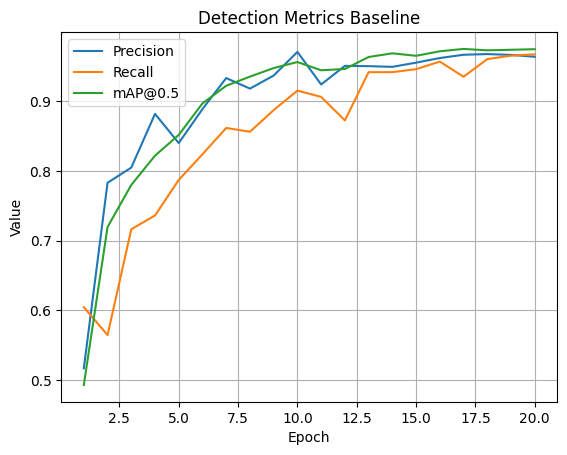

In [21]:
%matplotlib inline
results_dogs_v5i = pd.read_csv('runs/dogs_v5i/results.csv')

# Gruppieren nach Epoche und Mittelwert bilden
grouped_dogs_v5i = results_dogs_v5i.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped_dogs_v5i.index, grouped_dogs_v5i['metrics/precision(B)'], label='Precision')
plt.plot(grouped_dogs_v5i.index, grouped_dogs_v5i['metrics/recall(B)'], label='Recall')
plt.plot(grouped_dogs_v5i.index, grouped_dogs_v5i['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()

In [22]:
yaml_path = '../ASDF.v1i.yolov8/data.yaml'
train_yolo('asdf_v1i', yaml_path, epochs=20, batch=8, workers=4)

Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../ASDF.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=asdf_v1i, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

train: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1938.20it/s]

train: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 44.4±19.1 MB/s, size: 36.1 KB)


val: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/valid/labels... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 1332.83it/s]

val: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/valid/labels.cache


Plotting labels to runs/asdf_v1i/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/asdf_v1i
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.37G      1.397      2.929      1.724         19        640: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


                   all         12         12    0.00333          1      0.127     0.0578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.47G      1.488      2.616      1.785         20        640: 100%|██████████| 7/7 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]

                   all         12         12    0.00333          1      0.341      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.47G      1.419      2.346      1.722         19        640: 100%|██████████| 7/7 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]

                   all         12         12    0.00333          1      0.562       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.47G       1.55      2.351      1.797         15        640: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]

                   all         12         12    0.00333          1      0.578      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.47G      1.494      2.118      1.757         14        640: 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

                   all         12         12    0.00333          1      0.421      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.47G      1.572      2.252      1.808         12        640: 100%|██████████| 7/7 [00:00<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]

                   all         12         12    0.00333          1      0.335      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.47G      1.471      2.118       1.74         12        640: 100%|██████████| 7/7 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]

                   all         12         12    0.00333          1      0.229     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.47G       1.47       2.03      1.757         17        640: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]

                   all         12         12     0.0131      0.917      0.127     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.47G      1.391      2.096       1.72         22        640: 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]

                   all         12         12     0.0974      0.667      0.153     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.47G      1.392      1.995      1.701         17        640: 100%|██████████| 7/7 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]

                   all         12         12      0.407      0.167      0.231     0.0629


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.47G      1.398      2.469       1.92          8        640: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

                   all         12         12      0.438        0.5      0.407      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.47G       1.29      2.314      1.886          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all         12         12       0.25      0.167      0.316      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.47G      1.341      2.364       1.81          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

                   all         12         12       0.44      0.167        0.2      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.47G      1.255      2.278      1.739          8        640: 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]

                   all         12         12       0.44      0.167        0.2      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.47G      1.242      2.143      1.801          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]

                   all         12         12      0.204      0.417      0.259       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.49G       1.13       2.03      1.626          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

                   all         12         12      0.624      0.417      0.433      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.51G      1.123      1.984      1.608          8        640: 100%|██████████| 7/7 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all         12         12      0.592      0.417      0.533      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.52G      1.127      2.045      1.662          8        640: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

                   all         12         12      0.646      0.583      0.613       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.54G        1.1      1.939      1.716          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]

                   all         12         12      0.745      0.583      0.638      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.56G      1.017      1.864       1.53          8        640: 100%|██████████| 7/7 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

                   all         12         12      0.801      0.583      0.653      0.337



20 epochs completed in 0.005 hours.
Optimizer stripped from runs/asdf_v1i/weights/last.pt, 6.3MB
Optimizer stripped from runs/asdf_v1i/weights/best.pt, 6.3MB

Validating runs/asdf_v1i/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


                   all         12         12        0.8      0.583      0.655      0.337
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/asdf_v1i
✅ Training asdf_v1i abgeschlossen.


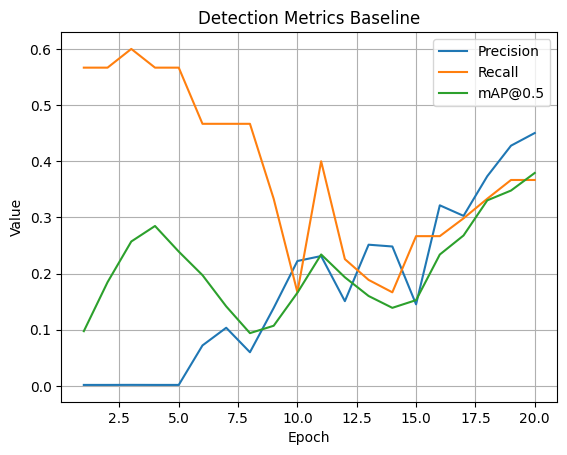

In [23]:
%matplotlib inline
results_asdf_v1i = pd.read_csv('runs/asdf_v1i/results.csv')

# Gruppieren nach Epoche und Mittelwert bilden
grouped_asdf_v1i = results_asdf_v1i.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/precision(B)'], label='Precision')
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/recall(B)'], label='Recall')
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()

In [24]:
yaml_path = '../kaggle_yolo/data.yaml'
train_yolo('kaggle', yaml_path, epochs=20, batch=8, workers=4)

Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../kaggle_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kaggle, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/kaggle_yolo/train/labels... 1567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1567/1567 [00:02<00:00, 555.36it/s]

train: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/kaggle_yolo/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 149.7±51.2 MB/s, size: 261.6 KB)


val: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/kaggle_yolo/valid/labels... 336 images, 0 backgrounds, 0 corrupt: 100%|██████████| 336/336 [00:00<00:00, 537.72it/s]

val: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/kaggle_yolo/valid/labels.cache


Plotting labels to runs/kaggle/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/kaggle
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.39G      1.131      1.903      1.398         23        640: 100%|██████████| 196/196 [00:17<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.86it/s]

                   all        336        336      0.775      0.765      0.836       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.72G       1.21      1.463      1.436         15        640: 100%|██████████| 196/196 [00:15<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.27it/s]

                   all        336        336       0.84      0.818      0.883      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.72G      1.269      1.287      1.465         12        640: 100%|██████████| 196/196 [00:15<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.54it/s]

                   all        336        336      0.739      0.771      0.815      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.72G      1.246       1.17      1.438         18        640: 100%|██████████| 196/196 [00:15<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]

                   all        336        336       0.86      0.842      0.909      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.72G      1.186      1.068      1.396         19        640: 100%|██████████| 196/196 [00:15<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]

                   all        336        336      0.799      0.819      0.876      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.72G      1.144      1.009      1.383         14        640: 100%|██████████| 196/196 [00:15<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.63it/s]

                   all        336        336      0.885      0.918      0.952       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.72G      1.118     0.9417      1.356         18        640: 100%|██████████| 196/196 [00:15<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]

                   all        336        336      0.857      0.866       0.93      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.72G      1.063     0.8738      1.323         19        640: 100%|██████████| 196/196 [00:15<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]

                   all        336        336      0.936      0.921      0.969      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.72G      1.037     0.8483      1.304         11        640: 100%|██████████| 196/196 [00:15<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.88it/s]

                   all        336        336      0.948      0.925      0.971      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.72G      1.003     0.8069      1.281          8        640: 100%|██████████| 196/196 [00:15<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.76it/s]

                   all        336        336      0.913      0.929      0.965       0.74


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.72G     0.9236     0.6531      1.259          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.75it/s]

                   all        336        336      0.954      0.943       0.98      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.72G     0.8609     0.5854      1.206          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 13.01it/s]

                   all        336        336      0.939      0.961      0.973      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.72G      0.824     0.5403       1.18          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]

                   all        336        336      0.952      0.937      0.977      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.72G     0.8135     0.5224       1.18          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]

                   all        336        336       0.97      0.964       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.72G     0.7586     0.4795      1.122          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]

                   all        336        336       0.97      0.965      0.988      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.72G     0.7102     0.4508      1.102          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 12.88it/s]

                   all        336        336      0.978      0.948      0.989      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.73G     0.6956     0.4268      1.082          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 13.14it/s]

                   all        336        336      0.985      0.958      0.988      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.74G     0.6565     0.4098      1.057          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 13.02it/s]

                   all        336        336      0.977      0.961      0.991      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.76G     0.6287     0.3814       1.04          7        640: 100%|██████████| 196/196 [00:15<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 13.01it/s]

                   all        336        336      0.984      0.979      0.991      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.78G      0.594     0.3657      1.018          7        640: 100%|██████████| 196/196 [00:15<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 13.17it/s]

                   all        336        336      0.985      0.973      0.992       0.85



20 epochs completed in 0.096 hours.
Optimizer stripped from runs/kaggle/weights/last.pt, 6.2MB
Optimizer stripped from runs/kaggle/weights/best.pt, 6.2MB

Validating runs/kaggle/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 11.38it/s]


                   all        336        336      0.985      0.974      0.992      0.851
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/kaggle
✅ Training kaggle abgeschlossen.


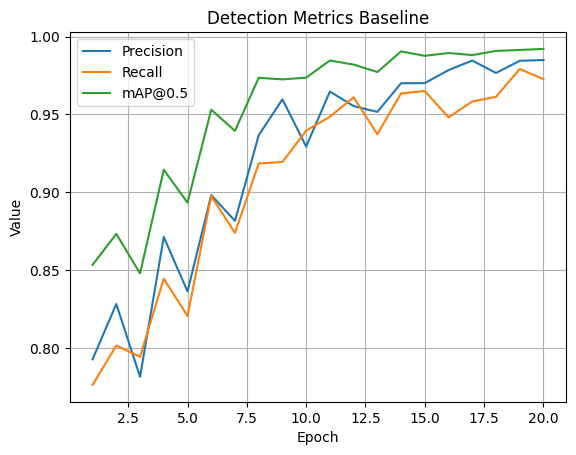

In [25]:
%matplotlib inline
results_kaggle = pd.read_csv('runs/kaggle/results.csv')

# Gruppieren nach Epoche und Mittelwert bilden
grouped_kaggle = results_kaggle.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped_kaggle.index, grouped_kaggle['metrics/precision(B)'], label='Precision')
plt.plot(grouped_kaggle.index, grouped_kaggle['metrics/recall(B)'], label='Recall')
plt.plot(grouped_kaggle.index, grouped_kaggle['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()

In [26]:
ds = Path("../ASDF.v1i.yolov8")
train_dir = ds/"train"
images_dir = train_dir/"images"
labels_dir = train_dir/"labels"
aug_dir  = ds/"train_upsampled"
aug_images = aug_dir/"images"
aug_labels = aug_dir/"labels"

In [29]:
# Augmentations-Pipeline definieren
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [32]:
def parse_yolo(txt_path):
    bboxes, labels = [], []
    for l in open(txt_path).read().splitlines():
        cls, x, y, w, h = l.split()
        labels.append(int(cls))
        bboxes.append([float(x), float(y), float(w), float(h)])
    return bboxes, labels

def save_yolo(txt_path, bboxes, labels):
    with open(txt_path, 'w') as f:
        for cls, bb in zip(labels, bboxes):
            x,y,w,h = bb
            f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

In [33]:
if aug_dir.exists():
    shutil.rmtree(aug_dir)
aug_images.mkdir(parents=True, exist_ok=True)
aug_labels.mkdir(parents=True, exist_ok=True)

# Upsampling: jedes Bild + Label K-mal augmentieren
K = 3
for img_path in images_dir.glob("*.*g"):
    stem = img_path.stem
    label_path = labels_dir/f"{stem}.txt"
    if not label_path.exists():
        continue

    # Ursprungsdatei kopieren
    shutil.copy2(img_path, aug_images/img_path.name)
    shutil.copy2(label_path, aug_labels/label_path.name)

    # augmentieren
    image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    bboxes, class_labels = parse_yolo(label_path)
    for i in range(K):
        out = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        bb2, cls2 = out['bboxes'], out['class_labels']
        if not bb2:
            continue
        aug_img = cv2.cvtColor(out['image'], cv2.COLOR_RGB2BGR)
        fname = f"{stem}_aug{i}.jpg"
        cv2.imwrite(str(aug_images/fname), aug_img)
        save_yolo(str(aug_labels/f"{stem}_aug{i}.txt"), bb2, cls2)

print(f"✅ Upsampled {len(list(images_dir.glob('*.*g')))} images x {K} → {len(list(aug_images.glob('*.*g')))} total")

✅ Upsampled 56 images x 3 → 224 total


In [34]:
# data.yaml anpassen (train-Pfad auf train_upsampled/images)
cfg_path = ds/"data.yaml"
cfg = yaml.safe_load(cfg_path.read_text())
cfg['train'] = 'train_upsampled/images'
with open(cfg_path, 'w') as f:
    yaml.dump(cfg, f, default_flow_style=False)
print("✅ data.yaml updated to use train_upsampled")

✅ data.yaml updated to use train_upsampled


In [35]:
ds        = Path("../ASDF.v1i.yolov8")
up_dir    = ds/"train_upsampled"
img_dir   = up_dir/"images"
lbl_dir   = up_dir/"labels"

# 3) Alle (Bild,Label)-Paare aus dem Upsampled-Ordner sammeln
pairs = [
    (img_p, lbl_dir/f"{img_p.stem}.txt")
    for img_p in img_dir.glob("*.*g")
    if (lbl_dir/f"{img_p.stem}.txt").exists()
]
print(f"Gefundene Paare: {len(pairs)}")

# 4) Shuffle & Split
train_pairs, rest = train_test_split(pairs, train_size=TRAIN_RATIO, random_state=SEED)
valid_pairs, test_pairs = train_test_split(
    rest,
    train_size=VALID_RATIO/(VALID_RATIO+TEST_RATIO),
    random_state=SEED
)

# 5) Alte Splits löschen (Bilder & Labels), aber data.yaml bleibt erhalten
for split in ("train","valid","test"):
    for sub in ("images","labels"):
        folder = ds/ split / sub
        if folder.exists():
            shutil.rmtree(folder)
        folder.mkdir(parents=True, exist_ok=True)

# 6) Neue Dateien kopieren
for img_p, lbl_p in train_pairs:
    shutil.copy2(img_p, ds/"train"/"images"/img_p.name)
    shutil.copy2(lbl_p, ds/"train"/"labels"/lbl_p.name)
print(f"→ train: {len(train_pairs)} Bilder")

for img_p, lbl_p in valid_pairs:
    shutil.copy2(img_p, ds/"valid"/"images"/img_p.name)
    shutil.copy2(lbl_p, ds/"valid"/"labels"/lbl_p.name)
print(f"→ valid: {len(valid_pairs)} Bilder")

for img_p, lbl_p in test_pairs:
    shutil.copy2(img_p, ds/"test"/"images"/img_p.name)
    shutil.copy2(lbl_p, ds/"test"/"labels"/lbl_p.name)
print(f"→ test:  {len(test_pairs)} Bilder")

print("\n✅ In-place Resplit für train_upsampled abgeschlossen (70/15/15).")

Gefundene Paare: 224
→ train: 156 Bilder
→ valid: 34 Bilder
→ test:  34 Bilder

✅ In-place Resplit für train_upsampled abgeschlossen (70/15/15).


In [36]:
yaml_path = '../ASDF.v1i.yolov8/data.yaml'
train_yolo('asdf_v1i_upsampled', yaml_path, epochs=20, batch=8, workers=4)

Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../ASDF.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=asdf_v1i_upsampled, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

train: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/train_upsampled/labels... 224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 2016.72it/s]

train: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/train_upsampled/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 85.3±16.1 MB/s, size: 52.2 KB)


val: Scanning /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/valid/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 1930.35it/s]

val: New cache created: /teamspace/studios/this_studio/dlbs-mc-oliver-fabian/ASDF.v1i.yolov8/valid/labels.cache


Plotting labels to runs/asdf_v1i_upsampled/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/asdf_v1i_upsampled
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.39G      1.572      2.555      1.911         27        640: 100%|██████████| 28/28 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]

                   all         34         34    0.00333          1      0.294      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.63G      1.503      2.387      1.862         19        640: 100%|██████████| 28/28 [00:02<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.65it/s]

                   all         34         34       0.65     0.0882      0.275      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.63G      1.572       2.24      1.898         17        640: 100%|██████████| 28/28 [00:03<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


                   all         34         34      0.278      0.324      0.265      0.089

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.63G      1.561      2.066      1.891         16        640: 100%|██████████| 28/28 [00:03<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         34         34      0.453      0.317      0.346      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.63G      1.582      2.016      1.883         13        640: 100%|██████████| 28/28 [00:03<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.09it/s]

                   all         34         34       0.17      0.382      0.181      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.63G      1.446      1.841      1.748         16        640: 100%|██████████| 28/28 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.90it/s]

                   all         34         34      0.333        0.5      0.339      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.63G      1.482      1.826      1.761         15        640: 100%|██████████| 28/28 [00:02<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.13it/s]

                   all         34         34       0.37      0.529      0.411      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.63G      1.467      1.719      1.757         20        640: 100%|██████████| 28/28 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.03it/s]

                   all         34         34      0.419      0.678      0.584      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.63G      1.406      1.689      1.703         20        640: 100%|██████████| 28/28 [00:02<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.26it/s]

                   all         34         34      0.866      0.618      0.764      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.63G      1.475      1.682      1.755         16        640: 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.00it/s]

                   all         34         34      0.901      0.806      0.895      0.514


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.63G      1.432      1.792      1.902          8        640: 100%|██████████| 28/28 [00:02<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.39it/s]

                   all         34         34      0.792      0.853      0.875      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.63G      1.357      1.736      1.898          8        640: 100%|██████████| 28/28 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.34it/s]

                   all         34         34      0.859      0.899      0.943      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.63G      1.224      1.474      1.804          8        640: 100%|██████████| 28/28 [00:02<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.36it/s]

                   all         34         34      0.968      0.824      0.962       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.63G      1.181       1.38      1.691          8        640: 100%|██████████| 28/28 [00:02<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.88it/s]

                   all         34         34      0.937       0.87      0.926       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.63G      1.174      1.339      1.742          8        640: 100%|██████████| 28/28 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.04it/s]

                   all         34         34      0.962      0.912      0.978      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.63G      1.103      1.247      1.625          8        640: 100%|██████████| 28/28 [00:02<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.79it/s]

                   all         34         34      0.995      0.882      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.63G      1.014      1.155      1.535          8        640: 100%|██████████| 28/28 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.06it/s]

                   all         34         34          1      0.868      0.982      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.63G      1.008      1.128      1.522          8        640: 100%|██████████| 28/28 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.44it/s]

                   all         34         34      0.965      0.882      0.944      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.63G      1.014      1.084      1.548          8        640: 100%|██████████| 28/28 [00:02<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.21it/s]

                   all         34         34      0.936       0.86      0.938      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.63G     0.9717      1.092      1.488          8        640: 100%|██████████| 28/28 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.71it/s]

                   all         34         34      0.959      0.882      0.954       0.76



20 epochs completed in 0.018 hours.
Optimizer stripped from runs/asdf_v1i_upsampled/weights/last.pt, 6.2MB
Optimizer stripped from runs/asdf_v1i_upsampled/weights/best.pt, 6.2MB

Validating runs/asdf_v1i_upsampled/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.10 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.76it/s]


                   all         34         34          1      0.869      0.982      0.768
Speed: 0.6ms preprocess, 2.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/asdf_v1i_upsampled
✅ Training asdf_v1i_upsampled abgeschlossen.


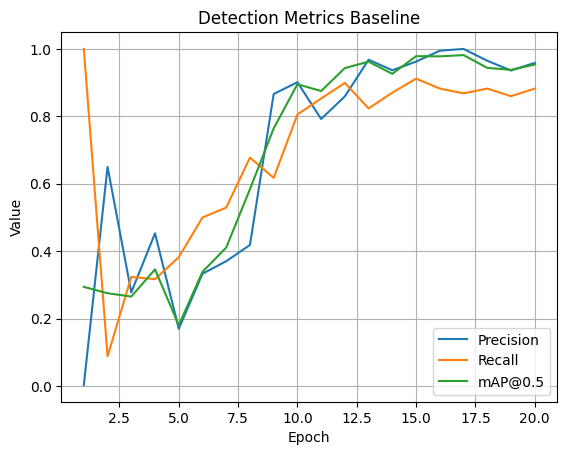

In [37]:
%matplotlib inline
results_asdf_v1i = pd.read_csv('runs/asdf_v1i_upsampled/results.csv')

# Gruppieren nach Epoche und Mittelwert bilden
grouped_asdf_v1i = results_asdf_v1i.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/precision(B)'], label='Precision')
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/recall(B)'], label='Recall')
plt.plot(grouped_asdf_v1i.index, grouped_asdf_v1i['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()